In [1]:
import sys
import os
searchPath=os.path.abspath('..')  # '../..' 代表添加当前路径的上两级目录；这种方法是运行时修改，脚本运行后就会失效
sys.path.append(searchPath)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
# 调整增加输出窗口显示数据
np.set_printoptions(precision=4, threshold=8, edgeitems=4, linewidth=75, suppress=True, nanstr='nan', infstr='inf')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
print('ready')

ready


In [2]:
# load data
file = 'scadaData.csv'
dataScada = pd.read_csv(file, index_col=False)  # encoding='GB18030'识别汉字表头；index_col=False 使得pandas不用第一列做索引（行名）
dataScada

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [3]:
dataScada.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [4]:
a=0
b=len(dataScada)
# Scada数据
serScada = pd.DataFrame(dataScada['Date/Time'][a:b].values, columns=['time'])  # 定义字典，装入数据,时间索引
serScada['time'] = pd.to_datetime(serScada['time'], format='%d %m %Y %H:%M')  # 4位年用Y，2位年用y
serScada['wind speed(m/s)'] = dataScada['Wind Speed (m/s)'][a:b].values
serScada['wind direction'] = dataScada['Wind Direction (°)'][a:b].values
serScada['theoretical power(kW)'] = dataScada['Theoretical_Power_Curve (KWh)'][a:b].values
serScada['active power(kW)'] = dataScada['LV ActivePower (kW)'][a:b].values
# 根据时间索引time列内容，删除重复记录的条目
serScada = serScada.drop_duplicates(subset='time')
# 用时间序列值作为index代替原序号标签
serScada.index = serScada['time'].values
serScada = serScada.drop(['time'],axis=1)
# 生成准确无误的时间序列，作为“时间基准”
time = pd.date_range(start='2018-1-1',end='2018-12-31 23:50',freq='10min')  # periods=b
serTime = pd.DataFrame({'num': np.array(range(len(time)))+1}, index = time)
# 与“时间序列基准”合并；删除“时间基准”中序号（此序号伴随无效数据有丢失）
serScada = pd.merge(serTime, serScada, left_index=True, right_index=True, how='inner')
serScada = serScada.drop(['num'],axis=1)
serScada = pd.merge(serTime, serScada, left_index=True, right_index=True, how='outer')
# 检查时间序列是否按照正常顺序排列
print('检查序列顺序:')
for i in range(len(serScada)):
    if i+1==serScada['num'][i]:
        continue
    else:
        print(i)
# 显示有空值的条目
print('检查空值:')
print(serScada[serScada.isnull().T.any()])
serScada=serScada.fillna(method="bfill", axis=0)   # 填充df中的空值 bfill:用后面数值填充 fill:用前面填充  填充方法可以进行优化
print(serScada[serScada.isnull().T.any()])
serScada

检查序列顺序:
检查空值:
                       num  wind speed(m/s)  wind direction  theoretical power(kW)  active power(kW)
2018-01-04 09:50:00    492              NaN             NaN                    NaN               NaN
2018-01-04 10:00:00    493              NaN             NaN                    NaN               NaN
2018-01-04 10:10:00    494              NaN             NaN                    NaN               NaN
2018-01-04 10:20:00    495              NaN             NaN                    NaN               NaN
2018-01-04 10:30:00    496              NaN             NaN                    NaN               NaN
...                    ...              ...             ...                    ...               ...
2018-12-17 10:10:00  50462              NaN             NaN                    NaN               NaN
2018-12-17 10:20:00  50463              NaN             NaN                    NaN               NaN
2018-12-17 10:30:00  50464              NaN             NaN                  

,num,wind speed(m/s),wind direction,theoretical power(kW),active power(kW)
2018-01-01 00:00:00,1,5.311336,259.994904,416.328908,380.047791
2018-01-01 00:10:00,2,5.672167,268.641113,519.917511,453.769196
2018-01-01 00:20:00,3,5.216037,272.564789,390.900016,306.376587
2018-01-01 00:30:00,4,5.659674,271.258087,516.127569,419.645905
2018-01-01 00:40:00,5,5.577941,265.674286,491.702972,380.650696
...,...,...,...,...,...
2018-12-31 23:10:00,52556,11.404030,80.502724,3397.190793,2963.980957
2018-12-31 23:20:00,52557,7.332648,84.062599,1173.055771,1684.353027
2018-12-31 23:30:00,52558,8.435358,84.742500,1788.284755,2201.106934
2018-12-31 23:40:00,52559,9.421366,84.297913,2418.382503,2515.694092


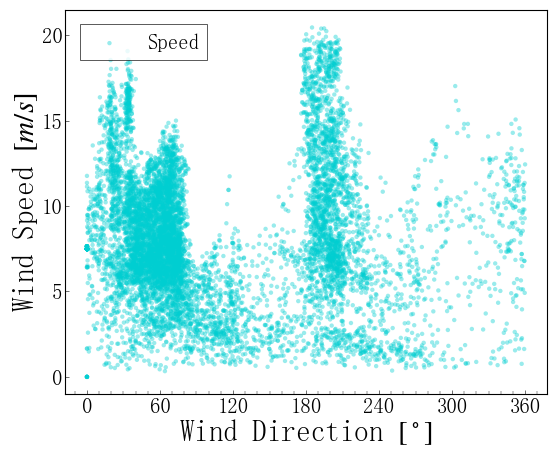

In [31]:
ser = serScada
s=40000
e=50000
x=ser.iloc[s:e,[2]]#dir
plot1=ser.iloc[s:e,[1]]  # speed
plot2=ser.iloc[s:e,[4]]  # power


# 将配置重置为默认值
plt.rcdefaults()
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
area = [10,10]  # 点面积[1.7,1.5]
plt.xlabel("Wind Direction $[\,^{\circ}\,]$", fontsize=21, labelpad=1)
plt.ylabel("Wind Speed $[m/s]$", fontsize=21, labelpad=1.3)
# plt.xlim(-2,22)
# plt.ylim(-200,3700)

# plt.scatter(x, plot2, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Active Power')
plt.scatter(x, plot1, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.4, label='Speed')

#修改主刻度
xmajorLocator = MultipleLocator(60) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
# ax.xaxis.set_major_formatter(xmajorFormatter)
# ymajorLocator = MultipleLocator(500) #将y轴主刻度标签设置为 的倍数
# ax.yaxis.set_major_locator(ymajorLocator)
# ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
# ax.yaxis.set_major_formatter(ymajorFormatter)

#修改次刻度
xminorLocator = MultipleLocator(10) #将x轴次刻度标签设置为5的倍数
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=15, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=15, direction='in', pad=1.8, length=2.7, width=0.4)
ax.tick_params(axis="x", which='minor', direction='in', length=2, width=0.3)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=2, width=0.3)#, color="green"

legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=15)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.tight_layout()
plt.savefig('output/scatter_speed_dir.png', dpi=600)
plt.show()
plt.close(fig)

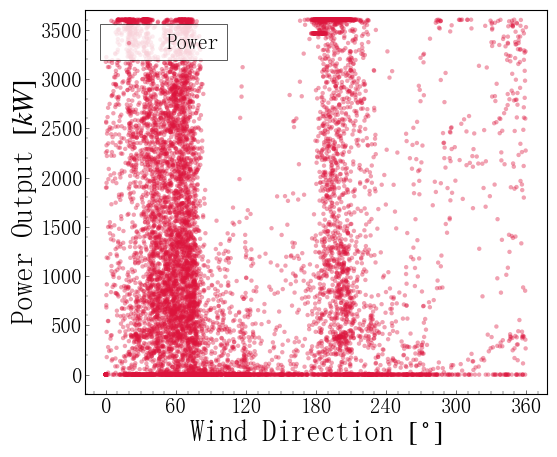

In [27]:
# 将配置重置为默认值
plt.rcdefaults()
# plt.rcParams['text.usetex'] = True  # 全局开启
# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示
# plt.rcParams['xtick.direction'] = 'in'  # 设置xtick和ytick的方向：in、out、inout
# plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
config = {
            "font.family": 'serif',
            "font.size": 21,
            "mathtext.fontset": 'stix',
            "font.serif": ['SimSun'],
         }
rcParams.update(config)

colors = ['#DC143C', '#00CED1']  #点的颜色
# fig = plt.figure(figsize=(3.5, 2.5), dpi=600)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
area = [10,10]  # 点面积[1.7,1.5]
plt.xlabel("Wind Direction $[\,^{\circ}\,]$", fontsize=21, labelpad=1)
plt.ylabel("Power Output $[kW]$", fontsize=21, labelpad=1.3)
# plt.xlim(-2,22)
plt.ylim(-200,3700)

# plt.scatter(x, plot2, s=area[1], marker='o', c=colors[1], edgecolors='none', alpha=0.6, label='Active Power')
plt.scatter(x, plot2, s=area[0], marker='o', c=colors[0], edgecolors='none', alpha=0.4, label='Power')

#修改主刻度
xmajorLocator = MultipleLocator(60) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# xmajorFormatter = FormatStrFormatter('%5.1d') #设置x轴标签文本的格式
# ax.xaxis.set_major_formatter(xmajorFormatter)
ymajorLocator = MultipleLocator(500) #将y轴主刻度标签设置为 的倍数
ax.yaxis.set_major_locator(ymajorLocator)
# ymajorFormatter = FormatStrFormatter('%4.1d') #设置y轴标签文本的格式
# ax.yaxis.set_major_formatter(ymajorFormatter)

#修改次刻度
xminorLocator = MultipleLocator(10) #将x轴次刻度标签设置为5的倍数
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(200) #将此y轴次刻度标签设置为0.1的倍数
ax.yaxis.set_minor_locator(yminorLocator)

ax.tick_params(axis='x', labelsize=15, direction='in', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=15, direction='in', pad=1.8, length=2.7, width=0.4)
ax.tick_params(axis="x", which='minor', direction='in', length=2, width=0.3)#, color="green"
ax.tick_params(axis="y", which='minor', direction='in', length=2, width=0.3)#, color="green"

legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=15)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

plt.tight_layout()
plt.savefig('output/scatter_power_dir.png', dpi=600)
plt.show()
plt.close(fig)

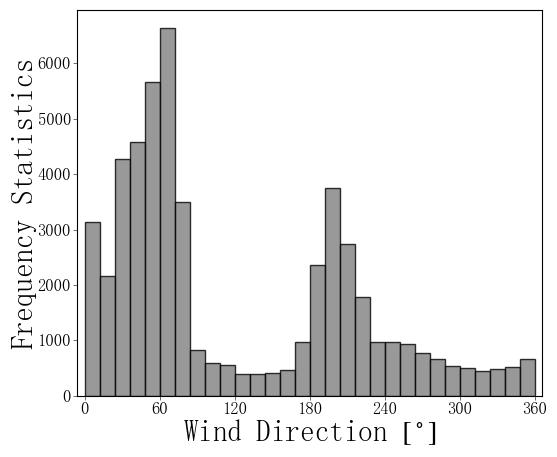

In [54]:
x = ser.iloc[:,[2]]#dir
# plt.hist(x, bins=20, range=None, normed=False,
# 	     weights=None, cumulative=False, bottom=None,
# 	     histtype='bar', align='mid', orientation='vertical',
# 	     rwidth=50, log=False, color=None,
# 	     label=None, stacked=False)
fig,ax = plt.subplots(figsize=(6, 5), dpi=100) #注意:一般都在ax中设置,不再plot中设置
plt.hist(x, bins = 30, alpha=0.8, color = 'gray', edgecolor = 'black')

plt.xlim(0-6,360+6)

plt.xlabel("Wind Direction $[\,^{\circ}\,]$", fontsize=21, labelpad=1)
plt.ylabel("Frequency Statistics", fontsize=21, labelpad=1)

xmajorLocator = MultipleLocator(60) #将x主刻度标签设置为 的倍数
ax.xaxis.set_major_locator(xmajorLocator)
# ymajorLocator = MultipleLocator(500) #将y轴主刻度标签设置为 的倍数
# ax.yaxis.set_major_locator(ymajorLocator)

ax.tick_params(axis='x', labelsize=12, direction='out', pad=1.8, length=2.7, width=0.4)  # 刻度值大小, rotation=40
ax.tick_params(axis='y', labelsize=12, direction='out', pad=1.8, length=2.7, width=0.4)

plt.tight_layout()
plt.savefig('output/scatter_dir.png', dpi=600)
plt.show()
plt.close(fig)